# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

# Import dataset

In [3]:
data_folder = 'Sales'  
all_month_data_2022 = pd.DataFrame()
all_month_data_2023 = pd.DataFrame()

for i in range(1, 13):
    filename = os.path.join(data_folder, f'TT T{i}-2022.csv')  
    if os.path.isfile(filename):
        data = pd.read_csv(filename)
        all_month_data_2022 = pd.concat([all_month_data_2022, data])
        
for i in range(1, 8):
    filename = os.path.join(data_folder, f'TT T{i}-2023.csv')  
    if os.path.isfile(filename):
        data = pd.read_csv(filename)
        all_month_data_2023 = pd.concat([all_month_data_2023, data])


all_month_data_2022['month'] = pd.to_datetime(all_month_data_2022['month'], format='%Y%m').dt.strftime('%Y-%m')
all_month_data_2022['week'] = all_month_data_2022['week'].astype(str).str.slice(-2)
#all_month_data_2022.set_index(('month','week)', inplace=True)
all_month_data_2022

,month,week,region,store_concept,store_type,address_3,address_2,channel_id,distribution_channel,sales_season,final_status,mch_description,name_description,sold_quantity,cost_price,net_price,customer_id,product_id
0,2022-01,01,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 6,CHTT,Bán lẻ,17DE,KHÁC,NHÓM HÀNG CHẬM,"Dép lào Nữ, Xanh nhớt, 39",1,51680,76000,dd5a95cfa,2429a82fe6274441abc1f4192d84c58cXNH39
1,2022-01,01,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 6,CHTT,Bán lẻ,18AP,KHÁC,NHÓM HÀNG CHẬM,"Dép lào Nữ, Xanh nhớt, 39",1,51680,76000,dd5a95cfa,2429a82fe6274441abc1f4192d84c58cXNH39
2,2022-01,01,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 6,CHTT,Bán lẻ,18AU,KHÁC,NHÓM HÀNG CHẬM,"Dép lào Nữ, Xanh nhớt, 39",1,51680,76000,dd5a95cfa,2429a82fe6274441abc1f4192d84c58cXNH39
3,2022-01,01,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 6,CHTT,Bán lẻ,18DE,KHÁC,NHÓM HÀNG CHẬM,"Dép lào Nữ, Xanh nhớt, 39",1,51680,76000,dd5a95cfa,2429a82fe6274441abc1f4192d84c58cXNH39
4,2022-01,01,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 6,CHTT,Bán lẻ,19AP,KHÁC,NHÓM HÀNG CHẬM,"Dép lào Nữ, Xanh nhớt, 39",1,51680,76000,dd5a95cfa,2429a82fe6274441abc1f4192d84c58cXNH39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384229,2022-12,52,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 1,CHTT,Bán lẻ,22AU,KHÁC,NHÓM PHỤ KIỆN HUNTER,"Vớ Hunter, Đen, 25",1,52743,78000,a0c1d36b9,54f3f366e6904d51a459a7ca1efa6fc1DEN25
384230,2022-12,52,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 1,CHTT,Bán lẻ,23AP,CORE,NHÓM PHỤ KIỆN HUNTER,"Vớ Hunter, Đen, 25",1,52743,78000,a0c1d36b9,54f3f366e6904d51a459a7ca1efa6fc1DEN25
384231,2022-12,52,KVMN,Cửa hàng B thông thường,Độc lập,TGG,Tx. Gò Công,CHTT,Bán lẻ,22DE,NEW,NHÓM 88,"SanDal Si - PU Nữ 88, Trắng, 39",1,250364,368000,c93dd7759,d77dcb0befd14f7ca0956bfe43afcc2cTRG39
384232,2022-12,52,KVMN,Cửa hàng B thông thường,Độc lập,TGG,Tx. Gò Công,CHTT,Bán lẻ,22AU,KHÁC,NHÓM 88,"SanDal Si - PU Nữ 88, Trắng, 39",1,250364,368000,c93dd7759,d77dcb0befd14f7ca0956bfe43afcc2cTRG39


In [4]:
all_month_data_2023['month'] = pd.to_datetime(all_month_data_2023['month'], format='%Y%m').dt.strftime('%Y-%m')
all_month_data_2023['week'] = all_month_data_2023['week'].astype(str).str.slice(-2)
all_month_data_2023

,month,week,region,store_concept,store_type,address_3,address_2,channel_id,distribution_channel,sales_season,final_status,mch_description,name_description,sold_quantity,cost_price,net_price,customer_id,product_id
0,2023-01,01,KVTN,Cửa hàng B thông thường,Độc lập,BĐH,Tx. An Nhơn,CHTT,Bán lẻ,22AP,Core,NHÓM PHỤ KIỆN,"Vớ bé trai Biti's combo 2, Xám, 23",2,70720,104000,36c1e6a9e,b3dacdf30b204b72be4ab8341d9f4559XAM23
1,2023-01,01,KVTN,Cửa hàng B thông thường,Độc lập,BĐH,Tx. An Nhơn,CHTT,Bán lẻ,22AU,CORE,NHÓM PHỤ KIỆN,"Vớ bé trai Biti's combo 2, Xám, 23",2,70720,104000,36c1e6a9e,b3dacdf30b204b72be4ab8341d9f4559XAM23
2,2023-01,01,KVTN,Cửa hàng B thông thường,Độc lập,BĐH,Tx. An Nhơn,CHTT,Bán lẻ,22DE,CORE,NHÓM PHỤ KIỆN,"Vớ bé trai Biti's combo 2, Xám, 23",2,70720,104000,36c1e6a9e,b3dacdf30b204b72be4ab8341d9f4559XAM23
3,2023-01,01,KVTN,Cửa hàng B thông thường,Độc lập,BĐH,Tx. An Nhơn,CHTT,Bán lẻ,23AP,CORE,NHÓM PHỤ KIỆN,"Vớ bé trai Biti's combo 2, Xám, 23",2,70720,104000,36c1e6a9e,b3dacdf30b204b72be4ab8341d9f4559XAM23
4,2023-01,01,KVTN,Cửa hàng B thông thường,Độc lập,BĐH,Tx. An Nhơn,CHTT,Bán lẻ,23AU,CORE,NHÓM PHỤ KIỆN,"Vớ bé trai Biti's combo 2, Xám, 23",2,70720,104000,36c1e6a9e,b3dacdf30b204b72be4ab8341d9f4559XAM23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213699,2023-07,31,KVMT,Cửa hàng B thông thường,Độc lập,BLU,Tx. Giá Rai,CHTT,Bán lẻ,23AP,KHÁC,NHÓM PHỤ KIỆN HUNTER,"Ba Lô Trẻ Em, Đen, 23",1,373750,565000,069196bb7,fe34ca3c40064aa5918e7184db86aeceDEN23
213700,2023-07,31,KVMN,Cửa hàng B thông thường,Độc lập,HCM,Q. 12,CHTT,Bán lẻ,23AU,CORE,NHÓM EVA PHUN,"SanDal EVA Phun BGái, Đen, 39",1,217600,315000,8e5c342e2,c2186b5368944463a9201d998d6d3d18DEN39
213701,2023-07,31,KVMN,Cửa hàng B thông thường,Độc lập,BTE,Tp. Bến Tre,CHTT,Bán lẻ,23AP,NEW,NHÓM EVA PHUN,"Sandal thông dụng đế Eva phun B, Xám, 40",1,217600,315000,4305de5ca,aa710eeba0774944bafaae4f88b6aadaXAM40
213702,2023-07,31,KVMT,Cửa hàng B thông thường,Độc lập,KGG,Tp. Rạch Giá,CHTT,Bán sỉ,22DE,CORE,NHÓM XỐP,"Dép Xốp Nam, Xanh dương, 43",1,136000,158605,f4eb82368,51b811dd86bf4a34a37cdd0a0904cd08XDG43


In [5]:
all_month_data_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5727698 entries, 0 to 384233
Data columns (total 18 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   month                 object
 1   week                  object
 2   region                object
 3   store_concept         object
 4   store_type            object
 5   address_3             object
 6   address_2             object
 7   channel_id            object
 8   distribution_channel  object
 9   sales_season          object
 10  final_status          object
 11  mch_description       object
 12  name_description      object
 13  sold_quantity         int64 
 14  cost_price            int64 
 15  net_price             int64 
 16  customer_id           object
 17  product_id            object
dtypes: int64(3), object(15)
memory usage: 830.3+ MB


In [6]:
all_month_data_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1539548 entries, 0 to 213703
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   month                 1539548 non-null  object
 1   week                  1539548 non-null  object
 2   region                1539548 non-null  object
 3   store_concept         1533106 non-null  object
 4   store_type            1539548 non-null  object
 5   address_3             1539548 non-null  object
 6   address_2             1539548 non-null  object
 7   channel_id            1539548 non-null  object
 8   distribution_channel  1539548 non-null  object
 9   sales_season          1539548 non-null  object
 10  final_status          1539548 non-null  object
 11  mch_description       1539548 non-null  object
 12  name_description      1539548 non-null  object
 13  sold_quantity         1539548 non-null  int64 
 14  cost_price            1539548 non-null  int64 
 15 

In [7]:
# Count the distinct occurrences of values in 'col1'
value_counts = all_month_data_2022['region'].append(all_month_data_2023['region']).value_counts()

# Print the result
print(value_counts)

KVMN          3639849
KVMT          1217771
KVMB          1155609
KVTN           776769
KVMTR          347297
Khác           109273
KVCA            19993
Trung Quốc        685
Name: region, dtype: int64


In [8]:
result_by_week = all_month_data_2022.groupby('week').sum().append(all_month_data_2023.groupby('week').sum())
result_by_week_and_region = all_month_data_2022.groupby(['week', 'region']).sum().append(all_month_data_2023.groupby(['week', 'region']).sum())

result_KVMN = result_by_week_and_region.loc[(slice(None), 'KVMN'), :]
result_KVMB = result_by_week_and_region.loc[(slice(None), 'KVMB'), :]
result_KVMT = result_by_week_and_region.loc[(slice(None), 'KVMT'), :]

In [9]:
result_by_month = all_month_data_2022.groupby('month').sum().append(all_month_data_2023.groupby('month').sum())
result_by_month_and_region = all_month_data_2022.groupby(['month', 'region']).sum().append(all_month_data_2023.groupby(['month', 'region']).sum())

result_KVMN_month = result_by_month_and_region.loc[(slice(None), 'KVMN'), :]
result_KVMB_month = result_by_month_and_region.loc[(slice(None), 'KVMB'), :]
result_KVMT_month = result_by_month_and_region.loc[(slice(None), 'KVMT'), :]

# Data preprocessing

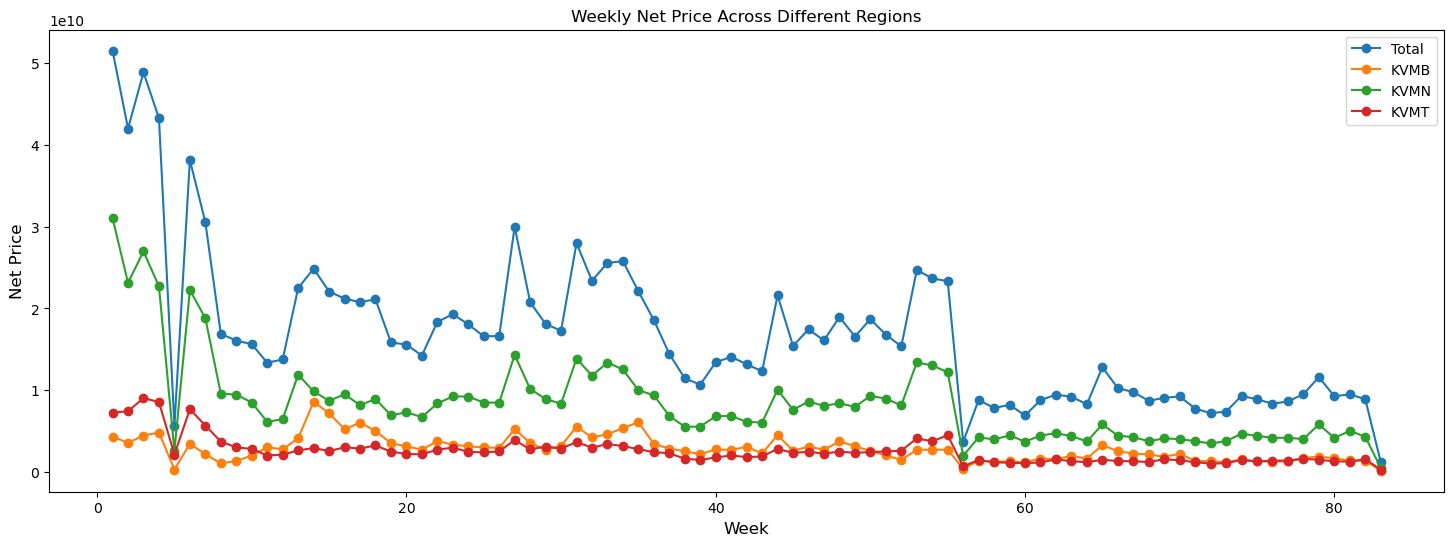

In [10]:
import matplotlib.pyplot as plt

def timeseries(x_axis, y_axis, label, linestyle='-', marker='o'):
    plt.plot(x_axis, y_axis, label=label, linestyle=linestyle, marker=marker)

# Assuming 'net_price' is the column you want to plot

plt.figure(figsize=(18, 6))

timeseries(range(1, 84),result_by_week['net_price'], "Total")
timeseries(range(1, 84),result_KVMB['net_price'], "KVMB")
timeseries(range(1, 84),result_KVMN['net_price'], "KVMN")
timeseries(range(1, 84),result_KVMT['net_price'], "KVMT") 

plt.title("Weekly Net Price Across Different Regions")
plt.xlabel("Week", fontsize=12)
plt.ylabel("Net Price", fontsize=12)
plt.legend()
plt.show()


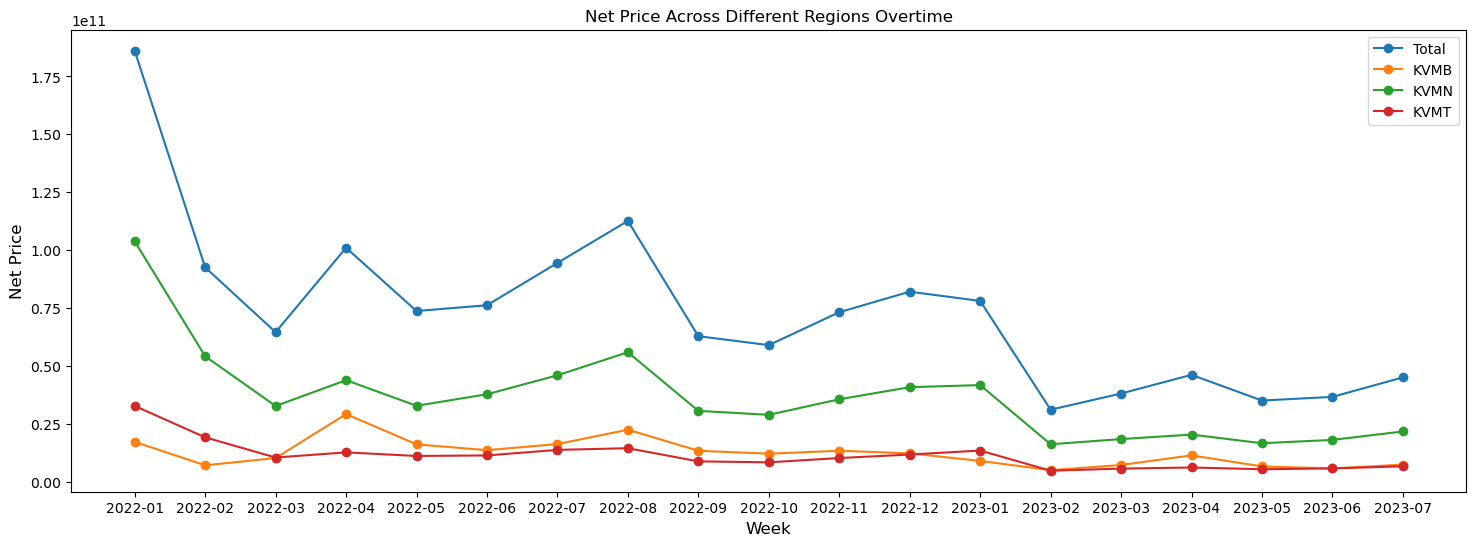

In [11]:
plt.figure(figsize=(18, 6))

timeseries(result_by_month.index,result_by_month['net_price'], "Total")
timeseries(result_by_month.index,result_KVMB_month['net_price'], "KVMB")
timeseries(result_by_month.index,result_KVMN_month['net_price'], "KVMN")
timeseries(result_by_month.index,result_KVMT_month['net_price'], "KVMT") 

plt.title("Net Price Across Different Regions Overtime")
plt.xlabel("Week", fontsize=12)
plt.ylabel("Net Price", fontsize=12)
plt.legend()
plt.show()

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Generate some example time series data  ,'cost_price'
# Hyperparameters
data_KVMB = result_KVMB[['net_price']]
data_KVMN = result_KVMN[['net_price']]
data_KVMT = result_KVMT[['net_price']]

# Concatenate data from different regions
data_KVMB = data_KVMB.reset_index(drop=True)  
data_KVMN = data_KVMN.reset_index(drop=True)
data_KVMT = data_KVMT.reset_index(drop=True)

data = pd.concat([data_KVMB, data_KVMN, data_KVMT], axis=1)

sequence_length = 79
num_epochs = 300
batch_size = 10
num_units = 50  # Number of LSTM units in each direction
forecast_horizon = 1  # Number of future values to forecast for about 1 month

# Preprocess the combined data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Create sequences for training
sequences = []
targets = []

for i in range(len(data) - sequence_length - forecast_horizon + 1):
    sequences.append(data_normalized[i:i + sequence_length])
    targets.append(data_normalized[i + sequence_length:i + sequence_length + forecast_horizon])

X_train = np.array(sequences)
y_train = np.array(targets)

In [13]:
# Build the parallel Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(num_units, input_shape=(sequence_length, 1))))
model.add(Dense(3 * forecast_horizon))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=10)

# Make predictions on the entire dataset
predictions_normalized = model.predict(X_train)

# Inverse transform the predictions to get them in the original scale
predictions_original_scale = scaler.inverse_transform(predictions_normalized)

predictions_original_scale

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

array([[1.1748835e+09, 3.4782408e+09, 1.1241388e+09],
       [1.1855892e+09, 3.5882954e+09, 1.1376995e+09],
       [1.2104009e+09, 3.5444416e+09, 1.1411877e+09],
       [1.1669489e+09, 3.4941338e+09, 1.1226538e+09]], dtype=float32)

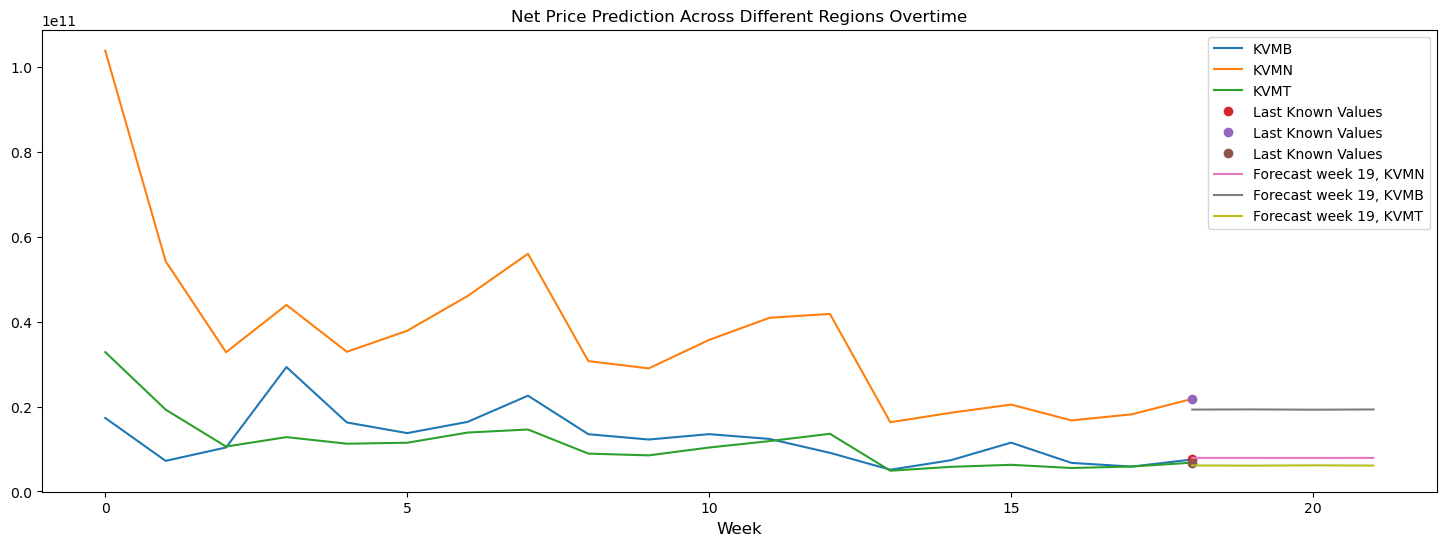

In [24]:
# Plot the results
plt.figure(figsize=(18, 6))
plt.plot(data, label=['KVMB', 'KVMN', 'KVMT'])
plt.title("Net Price Prediction Across Different Regions Overtime")
plt.xlabel("Week", fontsize=12)
# Plot the last known values in the original data
last_known_index = len(data) - forecast_horizon
plt.plot(range(last_known_index, len(data)), data.values[last_known_index:], 'o', label='Last Known Values')

# Plot the forecasted values for each region and each day
for i in range(forecast_horizon):
     plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
             predictions_original_scale[:, i], label=f'Forecast week {len(data)}, KVMN')

     plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
             predictions_original_scale[:, i + forecast_horizon], label=f'Forecast week {len(data)}, KVMB')
     
     plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
     predictions_original_scale[:, i + 2* forecast_horizon], label=f'Forecast week {len(data)}, KVMT')

plt.legend()
plt.show()

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Generate some example time series data  ,'cost_price'
np.random.seed(0)
# Replace this with your actual time series data
data_KVMB = result_KVMB_month[['net_price']]
data_KVMN = result_KVMN_month[['net_price']]
data_KVMT = result_KVMT_month[['net_price']]

# Concatenate data from different regions
data_KVMB = data_KVMB.reset_index(drop=True)  
data_KVMN = data_KVMN.reset_index(drop=True)
data_KVMT = data_KVMT.reset_index(drop=True)

data = pd.concat([data_KVMB, data_KVMN, data_KVMT], axis=1)


# Hyperparameters
sequence_length = 15
num_epochs = 300
batch_size = 10
num_units = 50  # Number of LSTM units in each direction
forecast_horizon = 1  # Number of future values to forecast

# Preprocess the combined data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Create sequences for training
sequences = []
targets = []

for i in range(len(data) - sequence_length - forecast_horizon + 1):
    sequences.append(data_normalized[i:i + sequence_length])
    targets.append(data_normalized[i + sequence_length:i + sequence_length + forecast_horizon])

X_train = np.array(sequences)
y_train = np.array(targets)

In [21]:
# Build the parallel Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(num_units, input_shape=(sequence_length, 1))))
model.add(Dense(3 * forecast_horizon))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=10)

# Make predictions on the entire dataset
predictions_normalized = model.predict(X_train)
# Inverse transform the predictions to get them in the original scale
predictions_original_scale = scaler.inverse_transform(predictions_normalized)

predictions_original_scale

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

array([[7.8972554e+09, 1.9285334e+10, 6.1192095e+09],
       [7.8969646e+09, 1.9321115e+10, 6.0776233e+09],
       [7.8921569e+09, 1.9257727e+10, 6.1454618e+09],
       [7.9003331e+09, 1.9311370e+10, 6.0926387e+09]], dtype=float32)

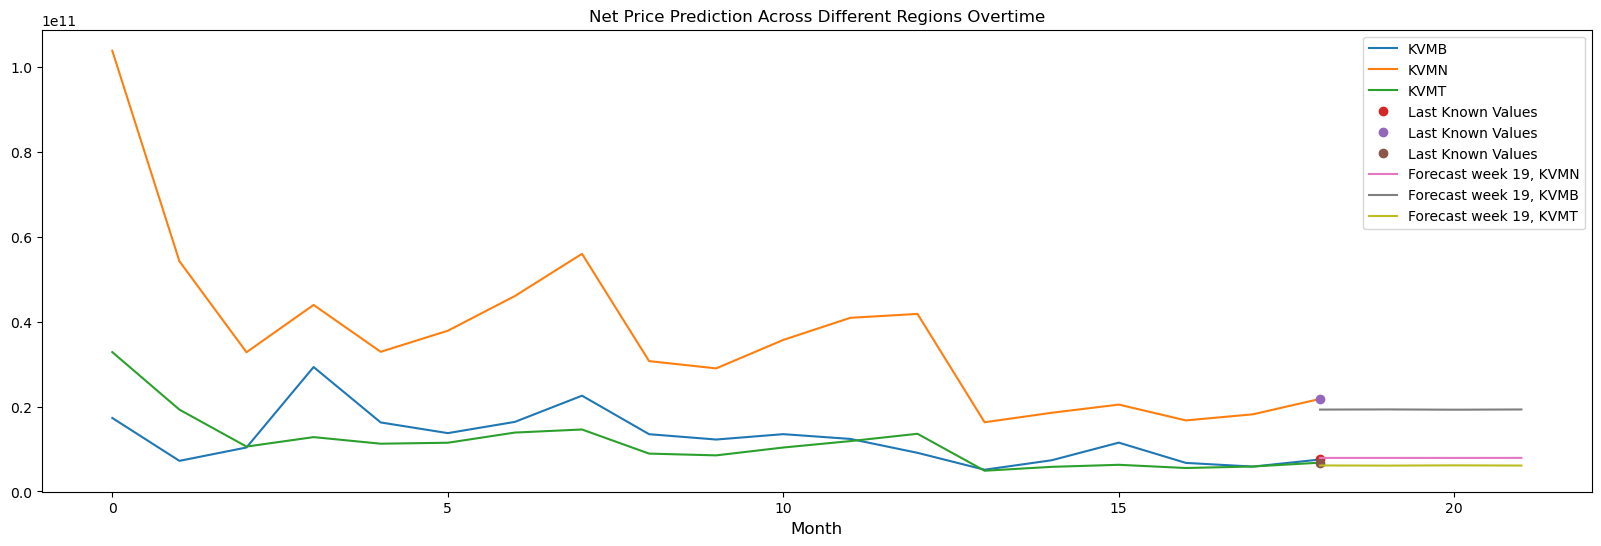

In [23]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(data, label=['KVMB', 'KVMN', 'KVMT'])
plt.title("Net Price Prediction Across Different Regions Overtime")
plt.xlabel("Month", fontsize=12)
# Plot the last known values in the original data
last_known_index = len(data) - forecast_horizon
plt.plot(range(last_known_index, len(data)), data[last_known_index:], 'o', label='Last Known Values')

# Plot the forecasted values
for i in range(forecast_horizon):
    plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
            predictions_original_scale[:, i], label=f'Forecast week {len(data)}, KVMN')

    plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
            predictions_original_scale[:, i + forecast_horizon], label=f'Forecast week {len(data)}, KVMB')

    plt.plot(range(last_known_index + i, last_known_index + len(predictions_original_scale)),
            predictions_original_scale[:, i + 2* forecast_horizon], label=f'Forecast week {len(data)}, KVMT')

plt.legend()
plt.show()